In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20000)

In [3]:
df_old = pd.read_csv('../data/preprocessed/cleaned_data_v2.csv', delimiter=",")

Todos:
- Farbe: One-hot-Enconding
- Extremwerte erkennen und Mittelwerte nehmen (Imputation)
- Delta increase = null rausfiltern (die ersten messwerte alle 0 setzen)

In [4]:
# Farbe One-Hot-Encoding
farbe_one_hot = pd.get_dummies(df_old.farbe,prefix='farbe')
df = pd.concat([df_old,farbe_one_hot],axis=1)
df.drop('farbe',1,inplace=True)

Auusage von FES:
Der Füllstand verläuft innerhalb der gleichen Min und Max Werte. Die Füllrate bei gleicher Einwurfmenge ist aber entsprechend unterschiedlich.

Daher schauen wir uns die Height werde erstmal im Histogramm an:

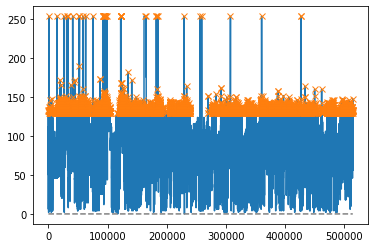

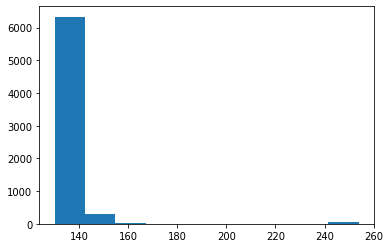

In [5]:
# Extremwerte erkennen
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

x = df.height_in_cm
peaks, _ = find_peaks(x, height=130)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()
plt.hist(x[peaks])
plt.show()

Ich gehe von Messfehlern ab height=140 aus. Es gibt sehr viele Werte über 140 deren vorgänger und nachfolger weit unter 100 liegen, daher werden alle Werte über 140 auf ihren Vorgänger gesetzt. Da wir das von Vergangenheit bis Zukunft durchführen, werden auch mehrere Messfehler hintereinander ausgebügelt.

In [6]:
df_new = df.copy()

for index, row in df_new.iterrows():
    if(row['height_in_cm'] > 140):
        df_new.loc[index, 'height_in_cm'] = df_new.loc[index-1, 'height_in_cm']

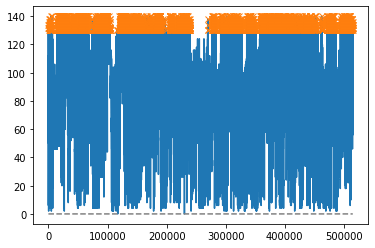

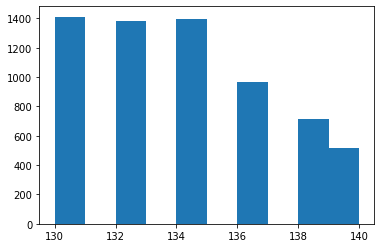

In [7]:
x = df_new.height_in_cm
peaks, _ = find_peaks(x, height=130)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()
plt.hist(x[peaks])
plt.show()

TODO Height Delta + Increase neu berechnen

In [19]:
# Replace null with 0.0
df_new["height_delta"].fillna(0.0, inplace = True)
df_new["height_increase"].fillna(0.0, inplace = True)

# Leerung erkennen
----> Hab ich nicht in den Export mitaufgenommen

Lokale Extremwerte finden --> Falls 3 Nachfolger unter ~50 dann ist eine Leerung erkannt?

Ich betrachte nur lokale Extremwerte mit height > 60, da die Nachfolgergrenze von 50 sonst ausversehen erreicht werden könnte.

In [9]:
x = df_new.height_in_cm
peaks, _ = find_peaks(x, height=60)

df_new_new = df_new.copy()
df_new_new['bereit_für_leerung'] = False

for index in peaks:
    if(df_new_new.loc[index, 'height_in_cm'] > 60 and
       df_new_new.loc[index+1, 'height_in_cm'] < 50 and
       df_new_new.loc[index+2, 'height_in_cm'] < 50 and
       df_new_new.loc[index+3, 'height_in_cm'] < 50):
        df_new_new.loc[index, 'bereit_für_leerung'] = True

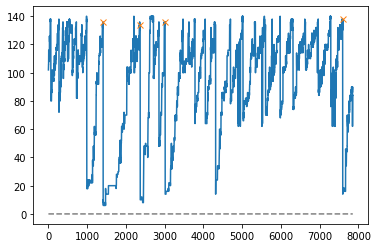

In [10]:
df1 = df_new_new[df_new_new['container_id'] == 10]
df1 = df1.reset_index()
x = df1.height_in_cm
leerung = df1.index[df1['bereit_für_leerung'] == True].tolist()
plt.plot(x)
plt.plot(leerung, x[leerung], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

# Export

In [11]:
df_new.to_csv('../data/preprocessed/cleaned_data_v3.csv', index=False)

In [12]:
df_new.head()

,id,container_id,messungszähler,height_in_cm,temperatur_in_grad,tilt_in_grad,niederschlag_in_mm,height_delta,height_increase,laengengrad,breitengrad,ist_industriegebiet,ist_wohngebiet,ist_feiertag,datum,sekunde,minute,stunde,wochentag,kalenderwoche,monat,jahr,DEVEUI_70B3D500700016DA,DEVEUI_70B3D500700016DE,DEVEUI_70B3D500700016DF,DEVEUI_70B3D500700016E0,DEVEUI_70B3D500700016E5,DEVEUI_70B3D500700016E6,DEVEUI_70B3D500700016E7,DEVEUI_70B3D500700016EB,DEVEUI_70B3D500700016EE,DEVEUI_70B3D500700016F1,DEVEUI_70B3D500700016F2,DEVEUI_70B3D500700016F4,DEVEUI_70B3D500700016F6,DEVEUI_70B3D500700016F7,DEVEUI_70B3D500700016FA,DEVEUI_70B3D500700016FC,DEVEUI_70B3D50070001700,DEVEUI_70B3D50070001701,DEVEUI_70B3D50070001704,DEVEUI_70B3D50070001706,DEVEUI_70B3D50070001708,DEVEUI_70B3D50070001709,DEVEUI_70B3D5007000170F,DEVEUI_70B3D50070001710,DEVEUI_70B3D50070001712,DEVEUI_70B3D50070001713,DEVEUI_70B3D50070001714,DEVEUI_70B3D50070001715,DEVEUI_70B3D50070001716,DEVEUI_70B3D5007000171A,DEVEUI_70B3D5007000171E,DEVEUI_70B3D5007000171F,DEVEUI_70B3D50070001722,DEVEUI_70B3D50070001724,DEVEUI_70B3D50070001725,DEVEUI_70B3D50070001726,DEVEUI_70B3D50070001727,DEVEUI_70B3D5007000172B,DEVEUI_70B3D5007000172C,DEVEUI_70B3D5007000172D,DEVEUI_70B3D5007000172E,DEVEUI_70B3D50070001730,DEVEUI_70B3D50070001731,DEVEUI_70B3D50070001733,DEVEUI_70B3D50070001734,DEVEUI_70B3D50070001736,DEVEUI_70B3D50070001737,DEVEUI_70B3D50070001738,DEVEUI_70B3D50070001739,DEVEUI_70B3D5007000173A,DEVEUI_70B3D5007000173C,DEVEUI_70B3D5007000173E,DEVEUI_70B3D50070001740,DEVEUI_70B3D50070001742,DEVEUI_70B3D50070001743,DEVEUI_70B3D50070001747,DEVEUI_70B3D5007000174D,DEVEUI_70B3D5007000174F,DEVEUI_70B3D50070001750,DEVEUI_70B3D50070001759,DEVEUI_70B3D5007000175A,DEVEUI_70B3D5007000175E,DEVEUI_70B3D50070001764,DEVEUI_70B3D50070001766,DEVEUI_70B3D50070001770,DEVEUI_70B3D50070001772,DEVEUI_70B3D50070001774,DEVEUI_70B3D50070001777,DEVEUI_70B3D50070001779,DEVEUI_70B3D5007000177C,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,farbe_brown,farbe_green,farbe_white
0,4110576,1,193,112,14.0,1,0.0,0.0,0.000000e+00,50.13464,8.71014,0,1,0,2021-05-08 20:26:00.596017,0,26,20,5,18,5,2021,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,4110093,1,192,112,17.0,1,0.0,4.0,1.109070e-06,50.13464,8.71014,0,1,0,2021-05-08 19:26:05.713448,5,26,19,5,18,5,2021,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,4109607,1,191,108,15.0,0,0.0,-18.0,-5.000290e-06,50.13464,8.71014,0,1,0,2021-05-08 18:25:59.323267,59,25,18,5,18,5,2021,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4109118,1,190,126,19.0,1,0.0,8.0,2.222260e-06,50.13464,8.71014,0,1,0,2021-05-08 17:25:59.523137,59,25,17,5,18,5,2021,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4108627,1,189,118,20.0,0,0.0,-4.0,-2.777940e-07,50.13464,8.71014,0,1,0,2021-05-08 16:25:59.577446,59,25,16,5,18,5,2021,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


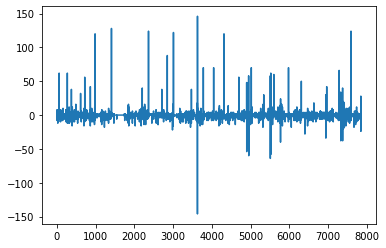

In [16]:
x = df1.height_delta
plt.plot(x)

plt.show()

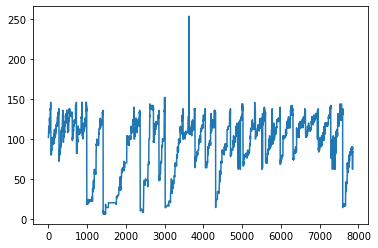

In [18]:
df1 = df[df['container_id'] == 10]
df1 = df1.reset_index()
x = df1.height_in_cm
plt.plot(x)

plt.show()